In [1]:
import pandas as pd
import numpy as np
import re

In [9]:
data=pd.read_excel('dataset_supplierfilled.xlsx')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24664 entries, 0 to 24663
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   청구서번호        24664 non-null  object 
 1   No.          24664 non-null  int64  
 2   Subject      24642 non-null  object 
 3   Machinery    24664 non-null  object 
 4   Assembly     24664 non-null  object 
 5   청구품목         24664 non-null  object 
 6   Unnamed: 6   0 non-null      float64
 7   Part No.1    24645 non-null  object 
 8   Part No.2    3599 non-null   object 
 9   청구량          24546 non-null  float64
 10  견적           24200 non-null  object 
 11  견적수량         24546 non-null  float64
 12  견적화폐         24546 non-null  object 
 13  견적단가         24664 non-null  float64
 14  발주번호         24664 non-null  object 
 15  발주처          24664 non-null  object 
 16  발주           24664 non-null  object 
 17  발주수량         24546 non-null  float64
 18  발주금액         24546 non-null  float64
 19  D/T 

> 숫자형 칼럼 처리 

In [11]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

numeric_cols = ['청구량', '견적단가', '발주금액', '창고입고수량', '선박입고수량']
data_numeric = data[numeric_cols].fillna(0)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_numeric)

data_scaled_df = pd.DataFrame(data_scaled, columns=numeric_cols)

print(data_scaled_df.head())

        청구량      견적단가      발주금액    창고입고수량  선박입고수량
0  0.000143  0.045800  0.001933  0.000143   0.004
1  0.000071  0.045805  0.001620  0.000071   0.002
2  0.000071  0.045834  0.005523  0.000071   0.002
3  0.000571  0.045821  0.031083  0.000571   0.002
4  0.000571  0.045821  0.031083  0.000571   0.014


> 텍스트 칼럼 처리

In [12]:
import re

# 텍스트 전처리 함수
def preprocess_text(text):
    if isinstance(text, float):  # 만약 text가 숫자형일 경우 빈 문자열로 처리
        return ''
    
    text = text.lower()
    text = re.sub(r'\([^)]*\)', '', text)  # 괄호 안의 내용 제거
    text = re.sub(r'[^\w\s\*/\-\+.,#&]', '', text)  # 특수문자 제거
    text = re.sub(r'\s+', ' ', text)  # 여러 공백을 하나로 변환
    text = re.sub(r'\b(사용금지|사)\b', '', text, flags=re.IGNORECASE)  # 특정 단어 제거
    text = text.strip()  # 양쪽 공백 제거
    return text

# 청구품목 결측값을 빈 문자열로 처리하고 전처리 적용
data['cleaned_item'] = data['청구품목'].fillna('').apply(preprocess_text)


In [13]:
def clean_supplier_name(name):
    name = name.lower()
    name = re.sub(r'coporation|coropration|coproration|corporration', 'corporation', name)
    name = re.sub(r'\(사용금지\)', '', name)
    name = re.sub(r'u\.s\.a', '_usa', name)
    name = re.sub(r'\.', '', name)
    suffixes = r'(corporation|corp|company|co|incorporated|inc|limited|ltd|상사|공사|엔지니어링|주식회사|주|gmbh|pte ltd|llc)'
    name = re.sub(suffixes, '', name, flags=re.IGNORECASE)
    name = re.sub(r'[^\w\s-]', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name

data['cleaned_supplier'] = data['발주처'].apply(clean_supplier_name)


### 특성 중요도 분석

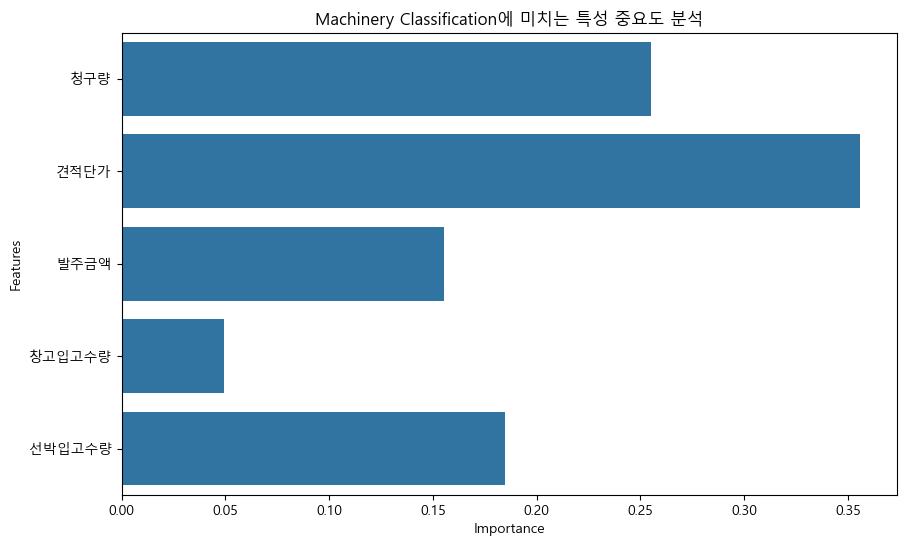

In [33]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터와 레이블 준비
X = data_scaled_df.values  # 숫자형 데이터 (스케일링된 값 사용)
y = y_machinery  # Machinery 레이블

# XGBoost 분류기 모델 생성 및 학습
model = XGBClassifier()
model.fit(X, y)

# 특성 중요도 추출
importance = model.feature_importances_

# 각 칼럼의 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=importance, y=data_scaled_df.columns)
plt.title("Machinery Classification에 미치는 특성 중요도 분석")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

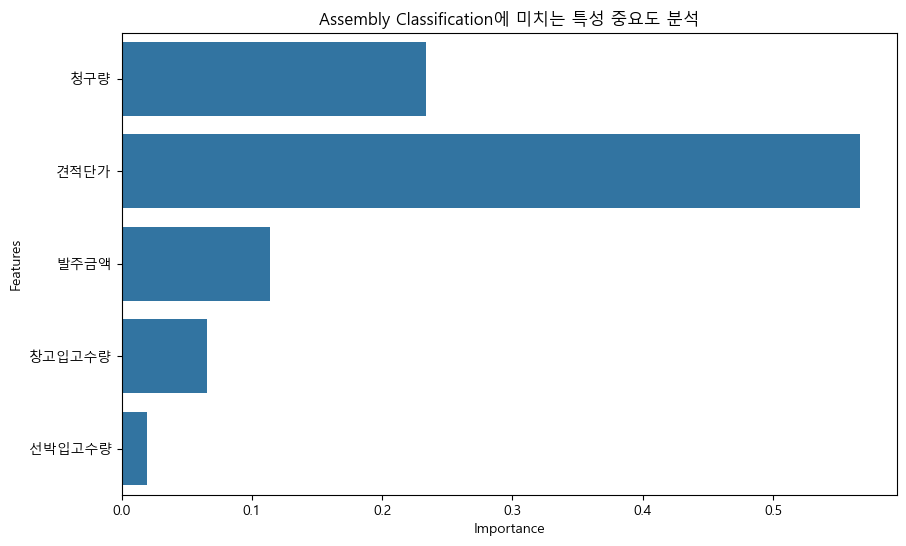

In [37]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터와 레이블 준비
X = data_scaled_df.values  # 숫자형 데이터 (스케일링된 값 사용)
y = y_assembly  # Machinery 레이블

# XGBoost 분류기 모델 생성 및 학습
model = XGBClassifier()
model.fit(X, y)

# 특성 중요도 추출
importance = model.feature_importances_

# 각 칼럼의 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=importance, y=data_scaled_df.columns)
plt.title("Assembly Classification에 미치는 특성 중요도 분석")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

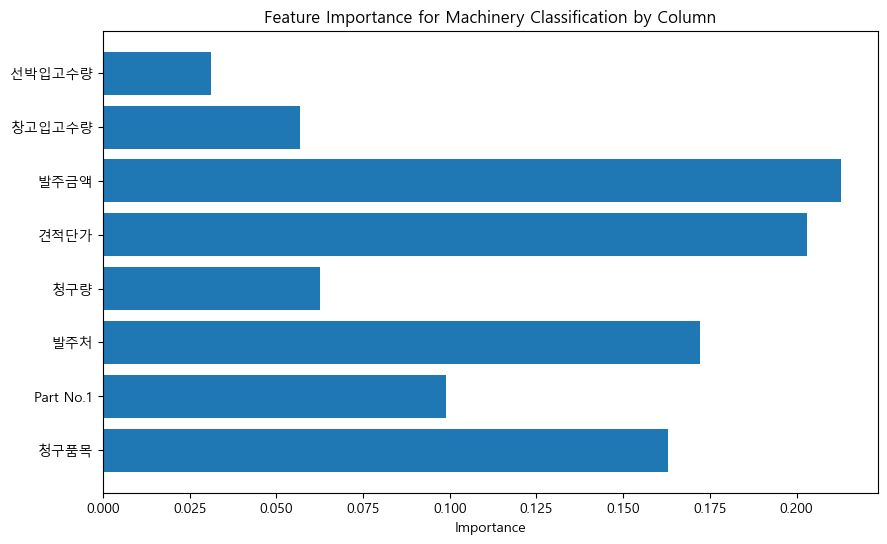

In [36]:
# 1. 텍스트 칼럼들을 벡터화하지 않고 칼럼 단위로 특성 중요도 확인
text_features_claim = tfidf.fit_transform(data['청구품목'].fillna('')).toarray().mean(axis=1)
text_features_partno = tfidf.fit_transform(data['Part No.1'].fillna('')).toarray().mean(axis=1)
text_features_supplier = tfidf.fit_transform(data['발주처'].fillna('')).toarray().mean(axis=1)

# 2. 각 칼럼에 대한 평균 TF-IDF 벡터를 하나의 특성으로 사용
numeric_features = data_scaled_df.values  # 숫자형 데이터

# 3. 결합된 텍스트 및 숫자형 데이터
X_combined = np.column_stack([text_features_claim, text_features_partno, text_features_supplier, numeric_features])

# 4. RandomForestClassifier를 사용하여 학습
rf = RandomForestClassifier()
rf.fit(X_combined, y_machinery)

# 5. 특성 중요도 계산
feature_importances = rf.feature_importances_

# 6. 각 칼럼 이름
combined_feature_names = ['청구품목', 'Part No.1', '발주처'] + list(data_scaled_df.columns)

# 7. 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align='center')
plt.yticks(range(len(feature_importances)), combined_feature_names)
plt.xlabel('Importance')
plt.title('Feature Importance for Machinery Classification by Column')
plt.show()

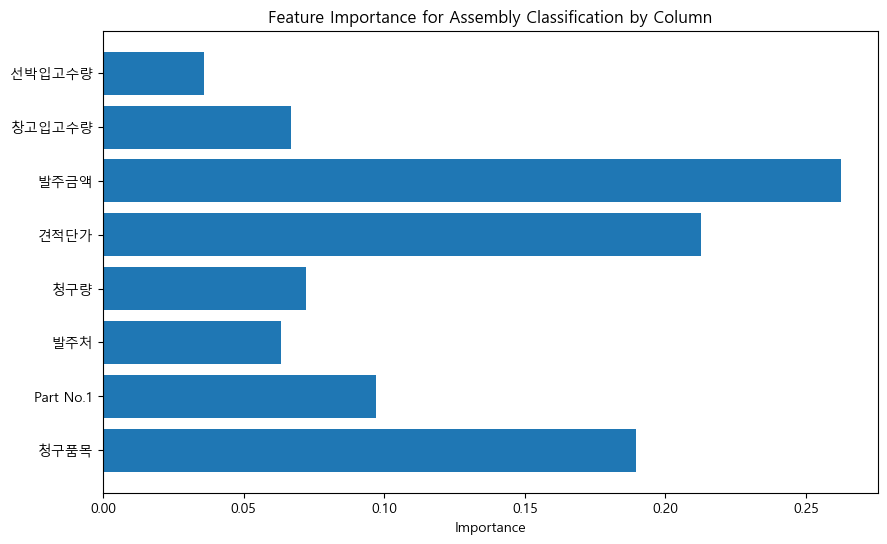

In [38]:
# 1. 텍스트 칼럼들을 벡터화하지 않고 칼럼 단위로 특성 중요도 확인
text_features_claim = tfidf.fit_transform(data['청구품목'].fillna('')).toarray().mean(axis=1)
text_features_partno = tfidf.fit_transform(data['Part No.1'].fillna('')).toarray().mean(axis=1)
text_features_supplier = tfidf.fit_transform(data['발주처'].fillna('')).toarray().mean(axis=1)

# 2. 각 칼럼에 대한 평균 TF-IDF 벡터를 하나의 특성으로 사용
numeric_features = data_scaled_df.values  # 숫자형 데이터

# 3. 결합된 텍스트 및 숫자형 데이터
X_combined = np.column_stack([text_features_claim, text_features_partno, text_features_supplier, numeric_features])

# 4. RandomForestClassifier를 사용하여 학습
rf = RandomForestClassifier()
rf.fit(X_combined, y_assembly)

# 5. 특성 중요도 계산
feature_importances = rf.feature_importances_

# 6. 각 칼럼 이름
combined_feature_names = ['청구품목', 'Part No.1', '발주처'] + list(data_scaled_df.columns)

# 7. 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align='center')
plt.yticks(range(len(feature_importances)), combined_feature_names)
plt.xlabel('Importance')
plt.title('Feature Importance for Assembly Classification by Column')
plt.show()

### 견적화폐 krw로 통일하여 피처 중요도 계산 세분화

In [39]:
data['견적화폐'].unique()

array(['USD', 'KRW', 'JPY', 'EUR', nan], dtype=object)

In [40]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

exchange_rates_to_krw = {'USD': 1300.0, 'KRW': 1.0, 'JPY': 9.5, 'EUR': 1450.0}

# 환율 적용 함수 (KRW 변환)
def convert_to_krw(row):
    currency = row['견적화폐']
    amount = row['견적단가']
    return amount * exchange_rates_to_krw.get(currency, 1)  # 화폐에 해당하는 값 없을 때 기본 1로 처리

# 모든 금액을 KRW로 변환하여 새로운 열 '견적단가_KRW' 생성
data['견적단가_KRW'] = data.apply(convert_to_krw, axis=1)

# 변환된 데이터 확인
print(data[['견적화폐', '견적단가', '견적단가_KRW']].head())

# 숫자형 칼럼을 스케일링 (MinMaxScaler 사용)
scaler = MinMaxScaler()
numeric_columns = ['청구량', '견적단가_KRW', '발주금액', '창고입고수량', '선박입고수량']  # 숫자형 칼럼
data_scaled = scaler.fit_transform(data[numeric_columns])

  견적화폐     견적단가   견적단가_KRW
0  USD  1022.76  1329588.0
1  USD  1713.96  2228148.0
2  USD  5843.75  7596875.0
3  USD  4000.00  5200000.0
4  USD  4000.00  5200000.0


In [41]:
# 스케일된 데이터를 DataFrame으로 변환
data_scaled_df = pd.DataFrame(data_scaled, columns=numeric_columns)


In [42]:
# 'Machinery'와 숫자형 칼럼 간의 상관관계 분석
machinery_labels = data['Machinery'].values
label_encoder_machinery = LabelEncoder()
y_machinery = label_encoder_machinery.fit_transform(machinery_labels)


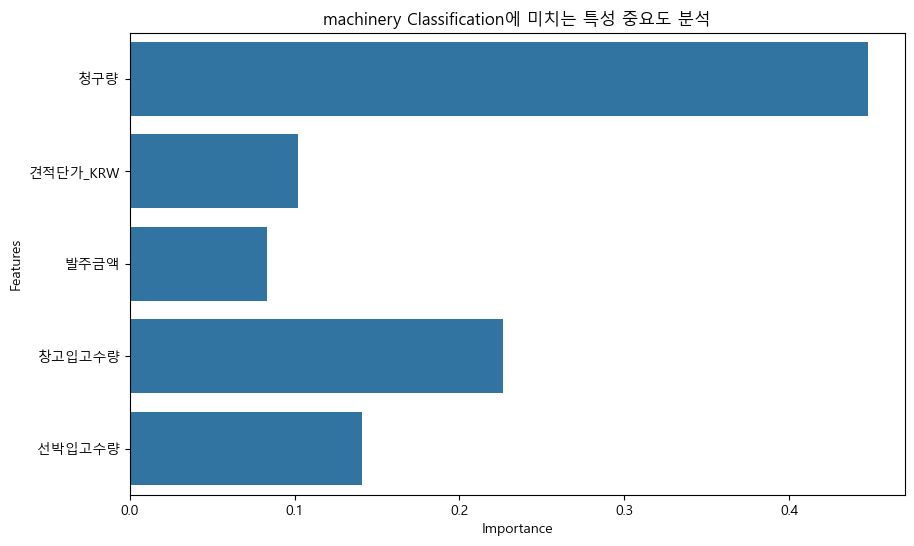

In [48]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터와 레이블 준비
X = data_scaled_df.values  # 숫자형 데이터 (스케일링된 값 사용)
y = y_machinery  # Machinery 레이블

# XGBoost 분류기 모델 생성 및 학습
model = XGBClassifier(random_state=42)
model.fit(X, y)

# 특성 중요도 추출
importance = model.feature_importances_

# 각 칼럼의 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=importance, y=data_scaled_df.columns)
plt.title("machinery Classification에 미치는 특성 중요도 분석")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

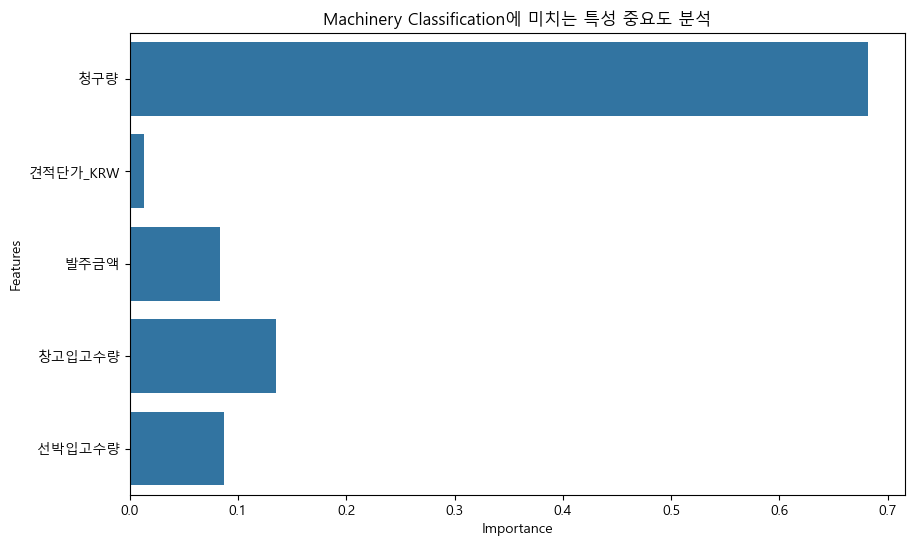

In [47]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터와 레이블 준비
X = data_scaled_df.values  # 숫자형 데이터 (스케일링된 값 사용)
y = y_assembly  # Machinery 레이블

# XGBoost 분류기 모델 생성 및 학습
model = XGBClassifier(random_state=42)
model.fit(X, y)

# 특성 중요도 추출
importance = model.feature_importances_

# 각 칼럼의 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=importance, y=data_scaled_df.columns)
plt.title("assembly Classification에 미치는 특성 중요도 분석")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [54]:
from sklearn.preprocessing import LabelEncoder

# 견적화폐 라벨 인코딩
label_encoder_currency = LabelEncoder()
data['encoded_currency'] = label_encoder_currency.fit_transform(data['견적화폐'])

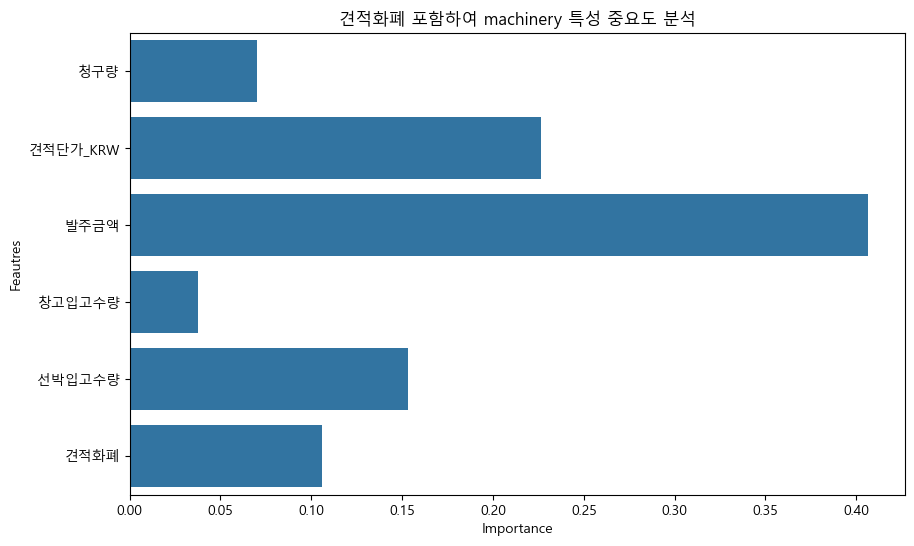

In [55]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

X = data_scaled_df.assign(currency=data['encoded_currency']).values
y = y_machinery

model = XGBClassifier()
model.fit(X, y)

importance = model.feature_importances_

plt.figure(figsize=(10,6))
sns.barplot(x=importance, y=data_scaled_df.columns.tolist() + ['견적화폐'])
plt.title("견적화폐 포함하여 machinery 특성 중요도 분석")
plt.xlabel("Importance")
plt.ylabel("Feautres")
plt.show()

In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel('dataset_supplierfilled.xlsx')

columns_to_use = ['Machinery', 'Assembly', '청구품목', 'Part No.1', '발주처', '견적화폐', '견적단가']
df = df[columns_to_use]

df = df.dropna()

In [63]:
# 레이블 인코딩
le = LabelEncoder()
for col in ['Machinery', 'Assembly', '청구품목', 'Part No.1', '발주처', '견적화폐']:
    df[col] = le.fit_transform(df[col].astype(str))